In [1]:

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# from keras import regularizers
# from keras import optimizers

# from sklearn.metrics import classification_report, confusion_matrix
# from sklearn.utils import class_weight

# from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
# import glob


In [2]:
batch_size = 16

def create_gender_model():
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size=3, input_shape=(150, 150, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.35))
    
    model.add(Conv2D(32, kernel_size=3, padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.35))
    
    model.add(Conv2D(64, kernel_size=3, padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.35))
    
    
    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.35))
    
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['binary_accuracy'])
    return model


    
gender_model = create_gender_model()                 # create the netwoek for the CNN

# we create an image data generator that randomly modifies an image
# so that we have better & more noisy data to train on
# we will get better generalisation performance
train_datagen = ImageDataGenerator(
#         rotation_range = 40,
#         width_shift_range=0.2,
#         height_shift_range=0.2,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True)
#         fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)

# generator will read pictures found in the specified directory
# classes are detected based on the folder
# will create random batches of the data it finds
train_generator = train_datagen.flow_from_directory(
    'Data/train_gender',  # this is the target directory
    target_size=(150, 150),  # all images will be resized to 150x150
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
val_generator = val_datagen.flow_from_directory(
    'Data/val_gender',
    target_size=(150, 150),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='binary')

#callbacks=[EarlyStopping(patience=3, restore_best_weights=True), 
#      ReduceLROnPlateau(patience=2), 
#     ModelCheckpoint(filepath='gender_model_chk.h5', save_best_only=True)] 


# finally, we train the model


STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=val_generator.n//val_generator.batch_size
gender_model.fit(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    epochs=6,
    validation_data=val_generator,
    validation_steps=STEP_SIZE_VALID
   )

# print out what each class means
print("class indices = " + str(train_generator.class_indices))

# save the model
gender_model.save_weights('gender_weights.h5')  # always save your weights after training or during training



Found 9699 images belonging to 2 classes.
Found 1209 images belonging to 2 classes.
Epoch 1/6
606/606 [==============================] - 1074s 2s/step - loss: 0.6396 - binary_accuracy: 0.6347 - val_loss: 0.6150 - val_binary_accuracy: 0.6492
Epoch 2/6
606/606 [==============================] - 246s 405ms/step - loss: 0.5682 - binary_accuracy: 0.7041 - val_loss: 0.5802 - val_binary_accuracy: 0.7208
Epoch 3/6
606/606 [==============================] - 252s 416ms/step - loss: 0.5277 - binary_accuracy: 0.7407 - val_loss: 0.5768 - val_binary_accuracy: 0.6825
Epoch 4/6
606/606 [==============================] - 251s 415ms/step - loss: 0.5093 - binary_accuracy: 0.7510 - val_loss: 0.5565 - val_binary_accuracy: 0.7325
Epoch 5/6
606/606 [==============================] - 257s 424ms/step - loss: 0.4864 - binary_accuracy: 0.7668 - val_loss: 0.5201 - val_binary_accuracy: 0.7625
Epoch 6/6
606/606 [==============================] - 259s 427ms/step - loss: 0.4781 - binary_accuracy: 0.7778 - val_loss: 0

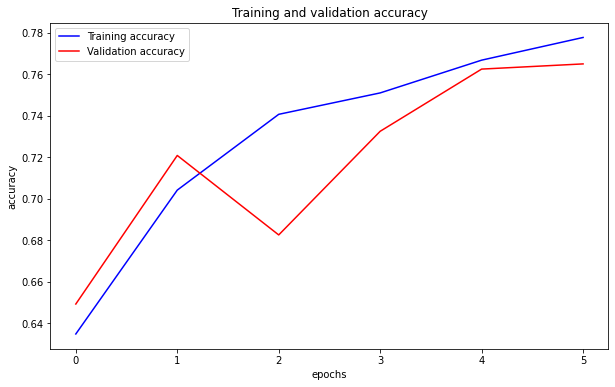

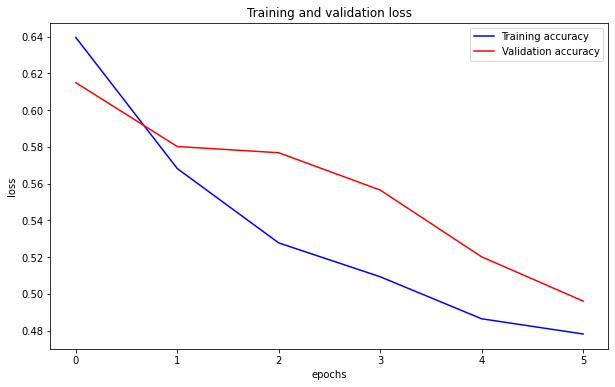

In [3]:
accuracy = gender_model.history.history['binary_accuracy']
val_accuracy = gender_model.history.history['val_binary_accuracy']
loss = gender_model.history.history['loss']
val_loss = gender_model.history.history['val_loss']
epochs = range(len(accuracy))

fig = plt.figure(figsize=(10,6)) 
plt.plot(epochs, accuracy, 'b', label = 'Training accuracy')
plt.plot(epochs,val_accuracy,'r', label= 'Validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Training and validation accuracy')
# txt = "Fig 1.b : "               # captioning the figure
# fig.text(.5, .05, txt, ha='center')
plt.legend()
plt.show()


fig = plt.figure(figsize=(10,6))
plt.plot(epochs, loss, 'b', label = 'Training accuracy')
plt.plot(epochs,val_loss,'r', label= 'Validation accuracy')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title("Training and validation loss")
plt.legend()

plt.show()


In [21]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    'Data/test_gender',
    target_size=(150, 150),
    color_mode="rgb",
    batch_size=4,
    class_mode=None,
    shuffle=False,
#     seed=42
)


STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()

# # model.evaluate_generator(generator=valid_generator,
# # steps=STEP_SIZE_VALID)

pred=gender_model.predict(test_generator,
steps=STEP_SIZE_TEST,
verbose=1)

y_pred = [ (1 if y[0] > 0.5 else 0) for y in pred]



# # labels = (train_generator.class_indices)
# # labels = dict((v,k) for k,v in labels.items())
# # predictions = [labels[k] for k in y_pred]

filenames=test_generator.filenames

results=pd.DataFrame({"Filenames":filenames,"Predicted Output": y_pred})
results.to_csv("prediction.txt",header= False, index= False, sep =' ')


Found 1204 images belonging to 1 classes.
301/301 [==============================] - 8s 25ms/step


In [22]:
from sklearn.metrics import accuracy_score
test_data = np.loadtxt('test_gender.txt', dtype=str)
y_predict = test_data[:,1].astype('int')
y_test = test_data[:,2].astype('int')

accuracy = accuracy_score(y_test,y_predict)   
print(accuracy)

0.7383720930232558


In [23]:
male= 0
female =0
for i in range(len(y_pred)):
    if y_pred[i]== 0:
        female+=1
    else:
        male+=1
print(male)
print(female)

602
602


In [36]:
batch_size = 64

def create_age_model():
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size=3, input_shape=(150, 150, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(32, kernel_size=3, padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, kernel_size=3, padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    
    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.3))
    
    model.add(Dense(8))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['categorical_accuracy'])
    return model


    
age_model = create_age_model()                 # create the netwoek for the CNN

# we create an image data generator that randomly modifies an image
# so that we have better & more noisy data to train on
# we will get better generalisation performance
train_agedatagen = ImageDataGenerator(
#         rotation_range = 40,
#         width_shift_range=0.2,
#         height_shift_range=0.2,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True)
#         fill_mode='nearest')
val_agedatagen = ImageDataGenerator(rescale=1./255)

# generator will read pictures found in the specified directory
# classes are detected based on the folder
# will create random batches of the data it finds
train_agegenerator = train_agedatagen.flow_from_directory(
    'Data/train_age',  # this is the target directory
    target_size=(150, 150),  # all images will be resized to 150x150
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
val_agegenerator = val_agedatagen.flow_from_directory(
    'Data/val_age',
    target_size=(150, 150),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical')

#callbacks=[EarlyStopping(patience=3, restore_best_weights=True), 
#      ReduceLROnPlateau(patience=2), 
#     ModelCheckpoint(filepath='gender_model_chk.h5', save_best_only=True)] 


# finally, we train the model


STEP_SIZE_TRAIN=train_agegenerator.n//train_agegenerator.batch_size
STEP_SIZE_VALID=val_agegenerator.n//val_agegenerator.batch_size
age_model.fit(
    train_agegenerator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    epochs=6,
    validation_data=val_agegenerator,
    validation_steps=STEP_SIZE_VALID
   )

# print out what each class means
print("class indices = " + str(train_agegenerator.class_indices))

# save the model
age_model.save_weights('age_weights.h5')  # always save your weights after training or during training


Found 10136 images belonging to 8 classes.
Found 1038 images belonging to 8 classes.
Epoch 1/6
633/633 [==============================] - 455s 720ms/step - loss: 1.8259 - categorical_accuracy: 0.3456 - val_loss: 1.7404 - val_categorical_accuracy: 0.3496
Epoch 2/6
633/633 [==============================] - 261s 413ms/step - loss: 1.5709 - categorical_accuracy: 0.4257 - val_loss: 1.6312 - val_categorical_accuracy: 0.3555
Epoch 3/6
633/633 [==============================] - 260s 411ms/step - loss: 1.4813 - categorical_accuracy: 0.4569 - val_loss: 1.5149 - val_categorical_accuracy: 0.3965
Epoch 4/6
633/633 [==============================] - 263s 416ms/step - loss: 1.4086 - categorical_accuracy: 0.4785 - val_loss: 1.5020 - val_categorical_accuracy: 0.3711
Epoch 5/6
633/633 [==============================] - 271s 428ms/step - loss: 1.3807 - categorical_accuracy: 0.4930 - val_loss: 1.5079 - val_categorical_accuracy: 0.3975
Epoch 6/6
633/633 [==============================] - 288s 455ms/step -

NameError: name 'model' is not defined

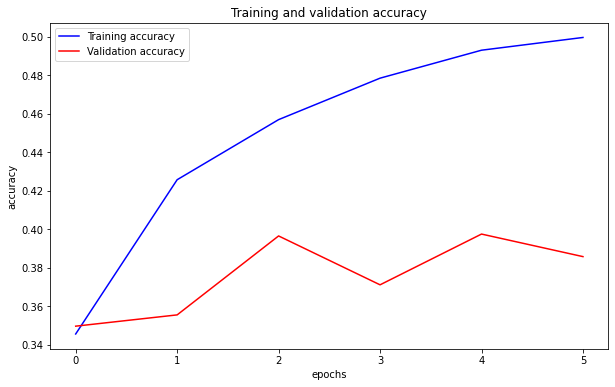

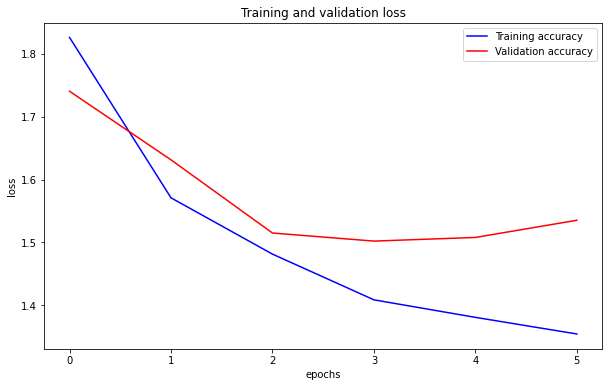

In [39]:
accuracy = age_model.history.history['categorical_accuracy']
val_accuracy = age_model.history.history['val_categorical_accuracy']
loss = age_model.history.history['loss']
val_loss = age_model.history.history['val_loss']
epochs = range(len(accuracy))

fig = plt.figure(figsize=(10,6)) 
plt.plot(epochs, accuracy, 'b', label = 'Training accuracy')
plt.plot(epochs,val_accuracy,'r', label= 'Validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Training and validation accuracy')
# txt = "Fig 1.b : "               # captioning the figure
# fig.text(.5, .05, txt, ha='center')
plt.legend()
plt.show()


fig = plt.figure(figsize=(10,6))
plt.plot(epochs, loss, 'b', label = 'Training accuracy')
plt.plot(epochs,val_loss,'r', label= 'Validation accuracy')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title("Training and validation loss")
plt.legend()

plt.show()
